In [1]:

#this model's parameters are got from the previous model mobilenet v2 

import torchvision


model_for_animal_classification_weights=torchvision.models.MobileNet_V2_Weights.DEFAULT

auto_tramsforms=model_for_animal_classification_weights.transforms()

model_for_animal_classification=torchvision.models.mobilenet_v2(weights=model_for_animal_classification_weights)

In [2]:
model_for_animal_classification

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [3]:
import torch
list_of_params=[torch.numel(param) for param in model_for_animal_classification.parameters()]
print(sum(list_of_params))

3504872


In [4]:
for param in model_for_animal_classification.parameters():
        param.requires_grad=False

In [5]:
#changing the classifier layer to suit for problem

model_for_animal_classification.classifier=torch.nn.Sequential(
        torch.nn.Dropout(p=0.2,inplace=False),
        torch.nn.Linear(in_features=1280,out_features=15,bias=True)
        

)


In [6]:
from torchinfo import summary

summary(model=model_for_animal_classification,input_size=(1,3,224,224),col_names=["input_size","output_size","num_params","trainable"])


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
MobileNetV2                                        [1, 3, 224, 224]          [1, 15]                   --                        Partial
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual: 2-2                       [

In [7]:
model_for_animal_classification.load_state_dict(torch.load(f="model_for_animal_classification.pth"))

C:\Users\yenug\AppData\Local\Temp\ipykernel_28960\3949517938.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_for_animal_classification.load_state_dict(torch.load(f

<All keys matched successfully>

In [8]:
model_for_animal_classification.classifier[1].weight

Parameter containing:
tensor([[-0.0031, -0.0839, -0.0913,  ...,  0.0284,  0.0431,  0.0471],
        [-0.0011, -0.0114,  0.0983,  ..., -0.0461,  0.0636, -0.0368],
        [ 0.0705,  0.0180, -0.0605,  ..., -0.0431, -0.0130, -0.0550],
        ...,
        [-0.0687, -0.0754, -0.0716,  ..., -0.0614, -0.0476, -0.0087],
        [-0.0765,  0.0371, -0.0178,  ...,  0.0399, -0.0173, -0.0457],
        [-0.0610,  0.0280, -0.0313,  ..., -0.0294, -0.0252, -0.0069]],
       requires_grad=True)

In [9]:
import os
from pathlib import Path

animal_classes_list=os.listdir(Path("animal_data"))
print(type(animal_classes_list))
print(animal_classes_list)

<class 'list'>
['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


In [10]:
next(iter(model_for_animal_classification.parameters())).device

device(type='cpu')

In [47]:
from timeit import default_timer as timer
from PIL import Image
def predict(img) -> list :
        start=timer()
        img=auto_tramsforms(img).unsqueeze(0)
        model_for_animal_classification.eval()
        with torch.inference_mode():
                prediciton_probabilities=torch.softmax(model_for_animal_classification(img),dim=1)
        prediction_probs_labels={animal_classes_list[i]:float(prediciton_probabilities[0,i]) for i in range(len(animal_classes_list))}
        pred_time=round(timer()-start,5)

        return prediction_probs_labels,pred_time,animal_classes_list[int(prediciton_probabilities.argmax(dim=1))]
        


In [48]:
import random
img=random.sample(list(Path("animal_data").rglob("*.jpg")),k=5)



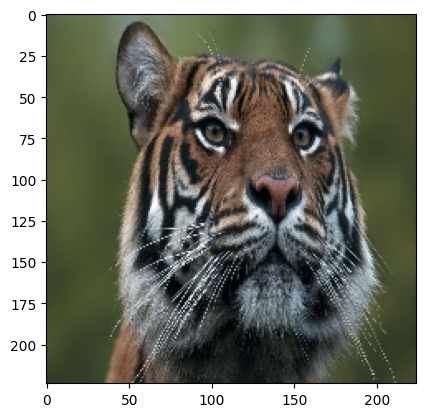

In [49]:
import matplotlib.pyplot as plt
plt.imshow(Image.open(img[0]))

In [50]:
example_list=[[str(file_path)] for file_path in random.sample(img,k=4)]
example_list

[['animal_data\\Kangaroo\\Kangaroo_14_2.jpg'],
 ['animal_data\\Zebra\\Zebra_18_3.jpg'],
 ['animal_data\\Tiger\\Tiger_11.jpg'],
 ['animal_data\\Horse\\Horse_19_1.jpg']]

In [51]:
import gradio as gr

title="Animal Classificaiton model Micro"
description=f"An mobile net v2 transfered model  to classify images of animals : {animal_classes_list}"
article="this model can be found on github repo : (https://github.com/SUJITH-REDDY-YENUGU?tab=repositories)"

demo=gr.Interface(
        fn=predict,
        inputs=gr.Image(type="pil"),
        outputs=[gr.Label(num_top_classes=15,label="Predictions"),
                 gr.Number(label="Prediction time"),
                 gr.Label(num_top_classes=1,label="Predicted animal ")],
        examples=example_list,
        title=title,
        description=description,
        article=article
)

demo.launch(debug=False,share=False)

* Running on local URL:  http://127.0.0.1:7871
* To create a public link, set `share=True` in `launch()`.


In [52]:
animal_classes_list

['Bear',
 'Bird',
 'Cat',
 'Cow',
 'Deer',
 'Dog',
 'Dolphin',
 'Elephant',
 'Giraffe',
 'Horse',
 'Kangaroo',
 'Lion',
 'Panda',
 'Tiger',
 'Zebra']